In [1]:
import sys
sys.path.append('../../code')
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
from numba import njit, prange

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [22]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx - 4 * np.pi ** 2 * tf.sin(np.pi * x) * tf.cos(np.pi * x)

def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    return np.sin(np.pi * x) * np.cos(np.pi * x)

geom = dde.geometry.Interval(-2, 2)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

Compiling model...
'compile' took 0.000348 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [2.73e+03, 3.21e-02]    [2.97e+03, 3.21e-02]    [2.91e+00]    
1000      [1.36e+00, 1.54e-01]    [1.60e+00, 1.54e-01]    [6.48e-01]    
2000      [6.76e-02, 9.28e-03]    [8.74e-02, 9.28e-03]    [1.80e-01]    
3000      [5.66e-02, 7.71e-06]    [6.92e-02, 7.71e-06]    [1.75e-02]    
4000      [5.00e-02, 7.57e-04]    [5.98e-02, 7.57e-04]    [3.54e-02]    
5000      [4.28e-02, 7.49e-04]    [5.10e-02, 7.49e-04]    [3.63e-02]    
6000      [3.35e-02, 5.76e-04]    [3.98e-02, 5.76e-04]    [3.29e-02]    
7000      [2.29e-02, 3.75e-04]    [2.70e-02, 3.75e-04]    [2.87e-02]    
8000      [1.34e-02, 1.89e-04]    [1.52e-02, 1.89e-04]    [2.48e-02]    
9000      [7.15e-03, 6.69e-05]    [7.47e-03, 6.69e-05]    [2.21e-02]    
10000     [4.28e-03, 1.64e-05]    [3.96e-03, 1.64e-05]    [2.01e-02]    

Best model at step 10000:
  train loss: 4.30e-03
  test lo

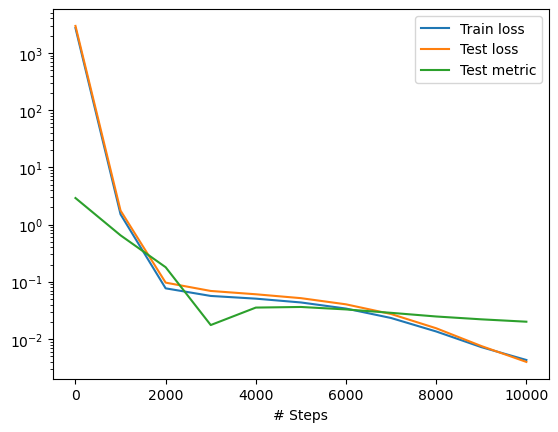

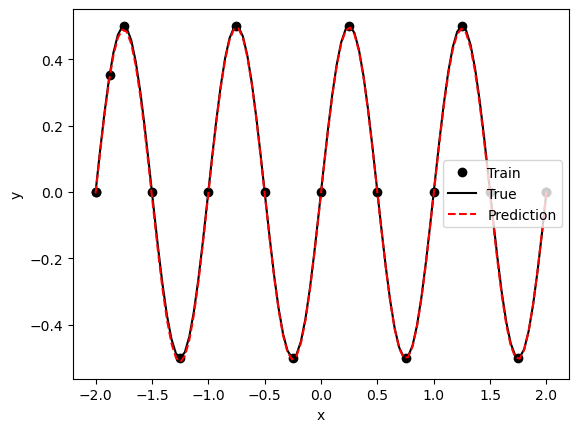

In [3]:
M =20
layer_size = [1] + [M]  +  [1]

activation = ["sin", 'linear']

initializer = "Glorot uniform"
R = 10
net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R/1000)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [25]:
R = 10
MM = [10, 20, 50, 100, 150, 200, 300]
loss = {}
epochs = {}
metric = {}
for M in MM:
    ll = []
    layer_size = [1] + [M]  +  [1]

    net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R/1000)

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])

    losshistory, train_state = model.train(iterations=10000)
    
    loss_test = losshistory.loss_test
    epochs[M] = losshistory.steps
    metric[M] = losshistory.metrics_test
    for j in range(np.shape(loss_test)[0]):
        ll.append(loss_test[j][0])
    loss[M] = ll

Compiling model...
'compile' took 0.000381 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [5.09e+03, 9.73e-01]    [4.85e+03, 9.73e-01]    [3.09e+00]    
1000      [2.03e+01, 1.51e-01]    [1.58e+01, 1.51e-01]    [6.76e-01]    
2000      [4.70e+00, 6.87e-02]    [5.43e+00, 6.87e-02]    [5.51e-01]    
3000      [4.04e+00, 1.02e-01]    [4.82e+00, 1.02e-01]    [4.10e-01]    
4000      [3.41e+00, 1.30e-01]    [4.09e+00, 1.30e-01]    [3.61e-01]    
5000      [2.64e+00, 1.11e-01]    [3.17e+00, 1.11e-01]    [3.18e-01]    
6000      [1.77e+00, 7.08e-02]    [2.12e+00, 7.08e-02]    [2.54e-01]    
7000      [9.52e-01, 3.32e-02]    [1.14e+00, 3.32e-02]    [1.77e-01]    
8000      [4.08e-01, 9.41e-03]    [4.71e-01, 9.41e-03]    [1.08e-01]    
9000      [1.82e-01, 1.09e-03]    [1.90e-01, 1.09e-03]    [7.86e-02]    
10000     [1.15e-01, 1.75e-05]    [1.08e-01, 1.75e-05]    [7.51e-02]    

Best model at step 10000:
  train loss: 1.15e-01
  test lo

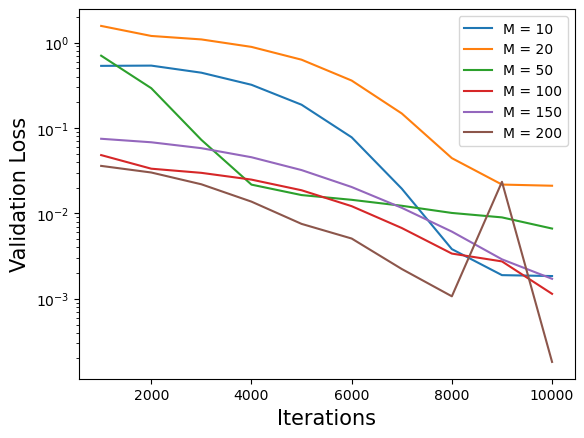

In [51]:
MM = [10, 20, 50, 100, 150, 200]

for i in MM:
    plt.plot(epochs[i][1:], loss[i][1:], label = 'M = ' + str(i))
plt.yscale('log')
#plt.title('Validation Loss')
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.legend()
plt.show()

Compiling model...
'compile' took 0.000329 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [3.80e+03, 1.48e+01]    [4.15e+03, 1.48e+01]    [1.21e+00]    
1000      [1.42e+01, 2.18e+00]    [9.15e+00, 2.18e+00]    [4.81e-01]    
2000      [2.91e+00, 8.87e-01]    [1.32e+00, 8.87e-01]    [2.87e-01]    
3000      [1.14e+00, 1.48e-01]    [6.81e-01, 1.48e-01]    [1.13e-01]    
4000      [7.21e-01, 8.53e-03]    [6.48e-01, 8.53e-03]    [2.78e-02]    
5000      [6.57e-01, 9.35e-04]    [6.67e-01, 9.35e-04]    [9.84e-03]    
6000      [6.07e-01, 1.09e-03]    [6.26e-01, 1.09e-03]    [1.05e-02]    
7000      [5.35e-01, 1.02e-03]    [5.53e-01, 1.02e-03]    [1.02e-02]    
8000      [4.38e-01, 7.77e-04]    [4.54e-01, 7.77e-04]    [8.94e-03]    
9000      [3.20e-01, 4.86e-04]    [3.33e-01, 4.86e-04]    [7.19e-03]    
10000     [2.04e-01, 2.15e-04]    [2.12e-01, 2.15e-04]    [4.98e-03]    
11000     [1.18e-01, 4.59e-05]    [1.20e-01, 4.59e-05]    [

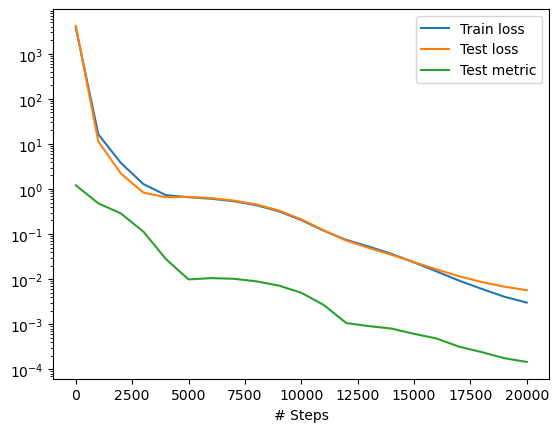

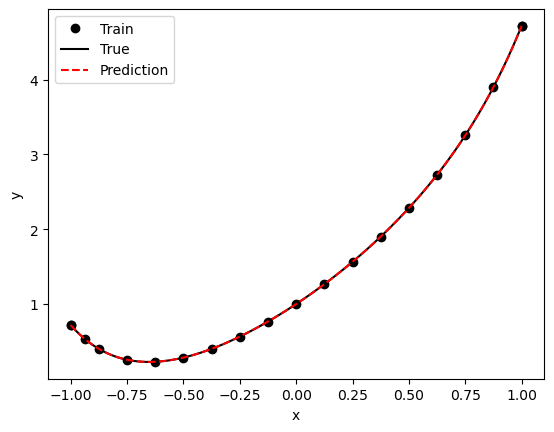

In [55]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx + 2*tf.exp(x**2) * (2*x**2 + 1)

def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    return np.exp(x**2) + 2*x

geom = dde.geometry.Interval(-1, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

M = 20
layer_size = [1] + [M]  +  [1]

activation = ["sin", 'linear']

initializer = "Glorot uniform"
R = 10
net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [47]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx + 2*tf.exp(x**2) * (2*x**2 + 1)

def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    return np.exp(x**2) + 2*x

geom = dde.geometry.Interval(-1, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

M = 100
layer_size = [1] + [M]  +  [1]

activation = ["sin", 'linear']

initializer = "Glorot uniform"

rr = [2, 4, 6, 8, 10, 12]

for R in rr:
    ll = []
    
    net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

    model = dde.Model(data, net)

    model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

    losshistory, train_state = model.train(iterations=10000)
    
    loss_test = losshistory.loss_test
    epochs[R] = losshistory.steps
    metric[R] = losshistory.metrics_test
    for j in range(np.shape(loss_test)[0]):
        ll.append(loss_test[j][0])
    loss[R] = ll

Compiling model...
'compile' took 0.000354 s



Training model...

Step      Train loss              Test loss               Test metric   
0         [7.71e+01, 1.10e+01]    [5.45e+01, 1.10e+01]    [8.47e-01]    
1000      [6.07e+00, 1.35e-01]    [2.36e+00, 1.35e-01]    [1.85e-01]    
2000      [2.24e+00, 1.04e-03]    [1.53e+00, 1.04e-03]    [3.36e-02]    
3000      [2.21e+00, 6.76e-05]    [1.65e+00, 6.76e-05]    [2.85e-02]    
4000      [2.19e+00, 6.08e-05]    [1.63e+00, 6.08e-05]    [2.84e-02]    
5000      [2.15e+00, 5.65e-05]    [1.61e+00, 5.65e-05]    [2.81e-02]    
6000      [2.09e+00, 5.23e-05]    [1.56e+00, 5.23e-05]    [2.77e-02]    
7000      [2.00e+00, 4.77e-05]    [1.49e+00, 4.77e-05]    [2.70e-02]    
8000      [1.86e+00, 4.16e-05]    [1.38e+00, 4.16e-05]    [2.60e-02]    
9000      [1.66e+00, 3.33e-05]    [1.23e+00, 3.33e-05]    [2.45e-02]    
10000     [1.41e+00, 2.41e-05]    [1.03e+00, 2.41e-05]    [2.24e-02]    

Best model at step 10000:
  train loss: 1.41e+00
  test loss: 1.03e+00
  test metric: [2.24e-02]

'train

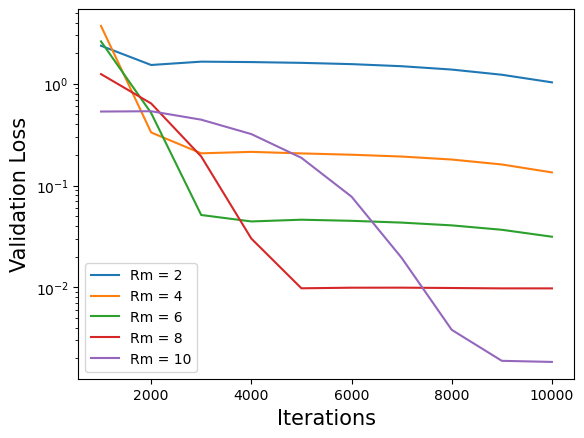

In [50]:
rr = [2, 4, 6, 8, 10]
for i in rr:
    plt.plot(epochs[i][1:], loss[i][1:], label = 'Rm = ' + str(i))
plt.yscale('log')
#plt.title('Validation Loss')
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.legend()
plt.show()

Compiling model...
'compile' took 0.000388 s



Training model...

Step      Train loss              Test loss               Test metric   
0         [1.76e+03, 3.84e+00]    [1.57e+03, 3.84e+00]    [1.23e+00]    
1000      [5.12e+00, 4.50e-01]    [4.72e+00, 4.50e-01]    [3.53e-01]    
2000      [6.86e-01, 8.53e-04]    [1.07e+00, 8.53e-04]    [8.22e-02]    
3000      [5.41e-01, 1.30e-03]    [8.60e-01, 1.30e-03]    [1.50e-02]    
4000      [4.70e-01, 1.11e-03]    [7.21e-01, 1.11e-03]    [1.33e-02]    
5000      [4.00e-01, 7.06e-04]    [5.97e-01, 7.06e-04]    [1.22e-02]    
6000      [3.15e-01, 4.94e-04]    [4.69e-01, 4.94e-04]    [1.11e-02]    
7000      [2.13e-01, 3.27e-04]    [3.27e-01, 3.27e-04]    [9.33e-03]    
8000      [1.14e-01, 1.69e-04]    [1.87e-01, 1.69e-04]    [7.06e-03]    
9000      [4.72e-02, 5.60e-05]    [8.86e-02, 5.60e-05]    [4.65e-03]    
10000     [1.79e-02, 1.26e-05]    [4.08e-02, 1.26e-05]    [2.90e-03]    
11000     [9.37e-03, 1.66e-06]    [2.39e-02, 1.66e-06]    [1.92e-03]    
12000     [7.52e-03, 1.85e-07]  

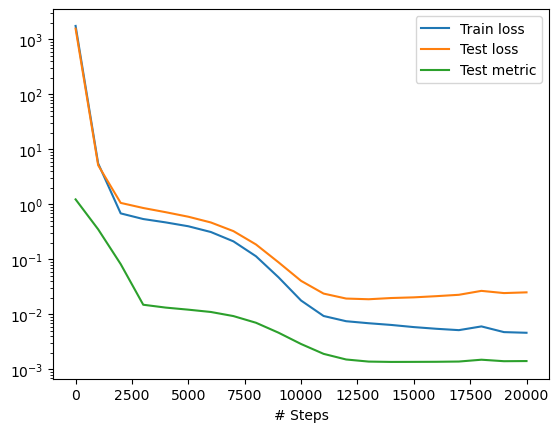

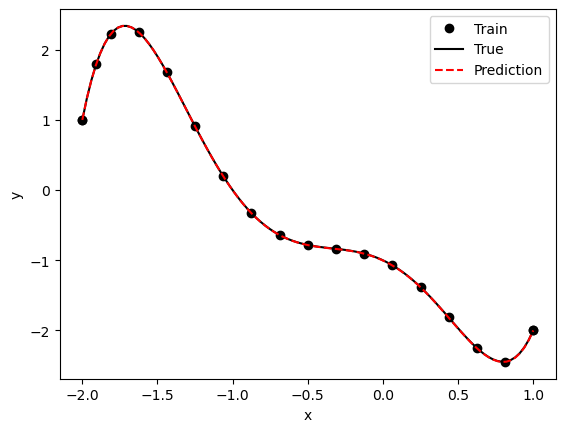

In [69]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx + 2*(10*x**3 + 12*x**2 - 3*x - 2)

def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    return x**5 + 2*x**4 -x**3 - 2*x**2 - x - 1
geom = dde.geometry.Interval(-2, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

M = 50
layer_size = [1] + [M]  +  [1]

activation = ["sin", 'linear']

initializer = "Glorot uniform"
R = 10
net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [70]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx + 2*(10*x**3 + 12*x**2 - 3*x - 2)

def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    return x**5 + 2*x**4 -x**3 - 2*x**2 - x - 1
geom = dde.geometry.Interval(-2, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

R = 10
MM = [5, 10, 20, 50, 100, 150, 200]
loss = {}
epochs = {}
metric = {}
for M in MM:
    ll = []
    layer_size = [1] + [M]  +  [1]

    net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])

    losshistory, train_state = model.train(iterations=10000)
    
    loss_test = losshistory.loss_test
    epochs[M] = losshistory.steps
    metric[M] = losshistory.metrics_test
    for j in range(np.shape(loss_test)[0]):
        ll.append(loss_test[j][0])
    loss[M] = ll


M = 50
layer_size = [1] + [M]  +  [1]

activation = ["sin", 'linear']

initializer = "Glorot uniform"

rr = [2, 4, 6, 8, 10, 12]

for R in rr:
    ll = []
    
    net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

    model = dde.Model(data, net)

    model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

    losshistory, train_state = model.train(iterations=10000)
    
    loss_test = losshistory.loss_test
    epochs[R] = losshistory.steps
    metric[R] = losshistory.metrics_test
    for j in range(np.shape(loss_test)[0]):
        ll.append(loss_test[j][0])
    loss[R] = ll

Compiling model...
'compile' took 0.000368 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.26e+03, 1.65e+00]    [9.27e+02, 1.65e+00]    [1.04e+00]    
1000      [3.37e+02, 1.43e+00]    [2.56e+02, 1.43e+00]    [1.01e+00]    
2000      [2.85e+02, 1.48e+00]    [2.20e+02, 1.48e+00]    [1.00e+00]    
3000      [2.54e+02, 1.66e+00]    [1.84e+02, 1.66e+00]    [9.80e-01]    
4000      [2.43e+02, 1.80e+00]    [1.70e+02, 1.80e+00]    [9.66e-01]    
5000      [2.42e+02, 1.86e+00]    [1.68e+02, 1.86e+00]    [9.60e-01]    
6000      [2.41e+02, 1.87e+00]    [1.67e+02, 1.87e+00]    [9.59e-01]    
7000      [2.41e+02, 1.87e+00]    [1.67e+02, 1.87e+00]    [9.59e-01]    
8000      [2.41e+02, 1.87e+00]    [1.67e+02, 1.87e+00]    [9.59e-01]    
9000      [2.41e+02, 1.87e+00]    [1.67e+02, 1.87e+00]    [9.59e-01]    
10000     [2.41e+02, 1.87e+00]    [1.67e+02, 1.87e+00]    [9.59e-01]    

Best model at step 7000:
  train loss: 2.43e+02
  test los

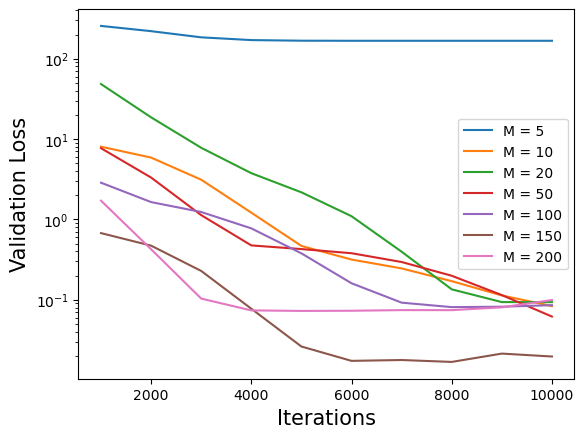

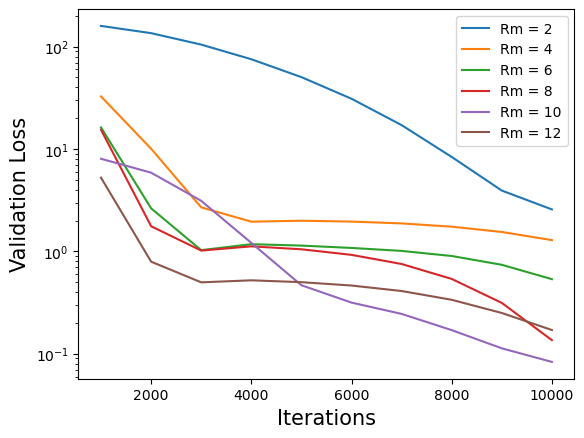

In [71]:
for i in MM:
    plt.plot(epochs[i][1:], loss[i][1:], label = 'M = ' + str(i))
plt.yscale('log')
#plt.title('Validation Loss')
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.legend()
plt.show()

for i in rr:
    plt.plot(epochs[i][1:], loss[i][1:], label = 'Rm = ' + str(i))
plt.yscale('log')
#plt.title('Validation Loss')
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.legend()
plt.show()

Compiling model...
'compile' took 0.000317 s



Training model...

Step      Train loss              Test loss               Test metric   
0         [2.48e+03, 1.07e+01]    [1.41e+03, 1.07e+01]    [1.03e+00]    
26        [1.15e-02, 4.19e-07]    [3.82e+01, 4.19e-07]    [5.76e-02]    

Best model at step 26:
  train loss: 1.15e-02
  test loss: 3.82e+01
  test metric: [5.76e-02]

'train' took 4.244157 s

Saving loss history to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\loss.dat ...
Saving training data to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\train.dat ...
Saving test data to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\test.dat ...


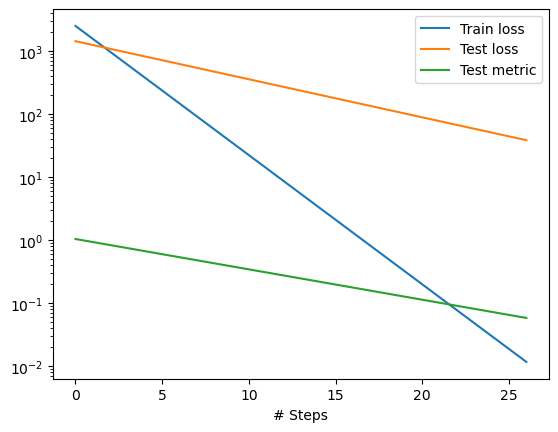

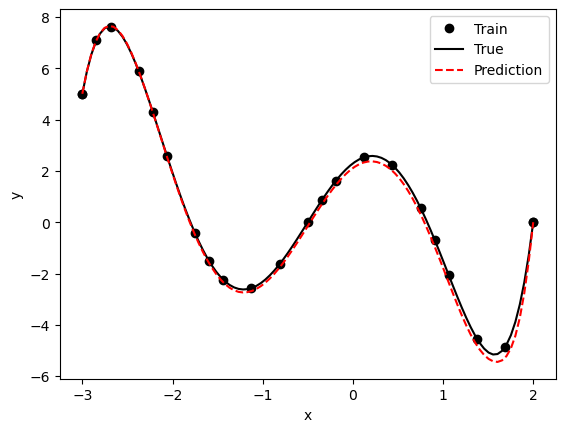

In [44]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx + 9.714*x**3 + 15.486*x**2 - 16.3572*x - 10.988

def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    return 0.4857*x**5 + 1.2905*x**4 - 2.7262*x**3 - 5.4940*x**2 + 2.6512*x + 2.2929

geom = dde.geometry.Interval(-3, 2)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 20, 2, solution=func, num_test=100)

M = 100
layer_size = [1] + [M]  +  [1]

activation = ["sin", 'linear']

initializer = "Glorot uniform"
R = 10
net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

model = dde.Model(data, net)

model.compile("L-BFGS", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

losshistory, train_state = model.train(iterations=30000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000303 s



Training model...

Step      Train loss              Test loss               Test metric   
0         [4.51e+03, 1.17e+01]    [4.13e+03, 1.17e+01]    [1.06e+00]    
50        [1.92e-03, 5.36e-09]    [4.61e-01, 5.36e-09]    [4.11e-01]    

Best model at step 50:
  train loss: 1.92e-03
  test loss: 4.61e-01
  test metric: [4.11e-01]

'train' took 5.617725 s

Saving loss history to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\loss.dat ...
Saving training data to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\train.dat ...
Saving test data to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\test.dat ...


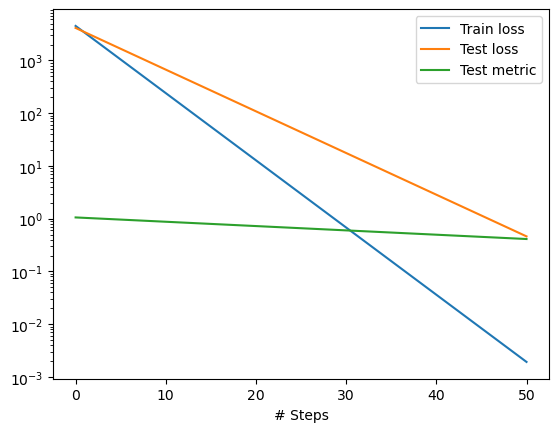

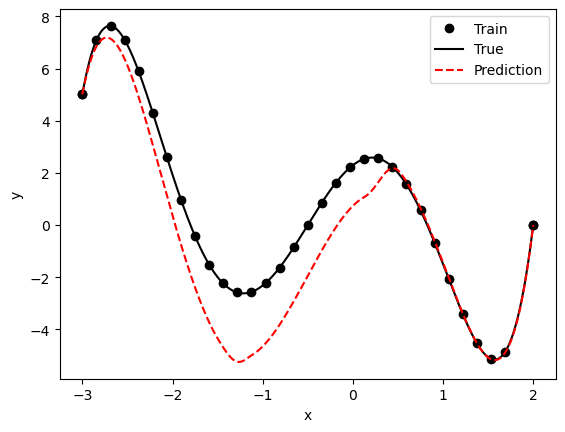

In [52]:
npart = 3
pi = np.pi

def psi_b(x):
    arr = np.ones((x.shape[0],1), dtype='float32')
    for i in range(x.shape[0]):
        if x[i] < -5/4 or x[i] > 5/4:
            arr[i] = 0
        elif x[i] >= -5/4 and x[i] <= -3/4:
            arr[i] = (1 + np.sin(2*pi*x[i]))/2
        elif x[i] >= 3/4 and x[i] <= 5/4:
            arr[i] = (1 - np.sin(2*pi*x[i]))/2
    
    return arr

def psi_a(x):
    arr = np.ones((x.shape[0],1), dtype='float32')
    for i in range(x.shape[0]):
        if x[i] < -5/4 or x[i] > 5/4:
            arr[i] = 0
        elif x[i] >= 3/4 and x[i] <= 5/4:
            arr[i] = (1 - np.sin(2*pi*x[i]))/2
    return arr

def psi_c(x):
    arr = np.ones((x.shape[0],1), dtype='float32')
    for i in range(x.shape[0]):
        if x[i] < -5/4 or x[i] > 5/4:
            arr[i] = 0
        elif x[i] >= -5/4 and x[i] <= -3/4:
            arr[i] = (1 + np.sin(2*pi*x[i]))/2
        
    return arr

def indicatrice_a(a,b):
    return lambda x: psi_a((2*x-b-a)/(b-a))

def indicatrice_b(a,b):
    return lambda x: psi_b((2*x-b-a)/(b-a))

def indicatrice_c(a,b):
    return lambda x: psi_c((2*x-b-a)/(b-a))

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx + 9.714*x**3 + 15.486*x**2 - 16.3572*x - 10.988

def boundary(x, on_boundary, npart=npart):
    return on_boundary

def func(x):
    return 0.4857*x**5 + 1.2905*x**4 - 2.7262*x**3 - 5.4940*x**2 + 2.6512*x + 2.2929

geom = dde.geometry.Interval(-3, 2)
bc = dde.icbc.DirichletBC(geom, func, boundary, npart=npart)
data = dde.data.PDE(geom, pde, bc, 30, 2, solution=func, num_test=500)

arr = np.linspace(-3, 2, npart + 1)
nn_indicatrici = [indicatrice_b(arr[i], arr[i+1]) for i in range(1,npart-1)]
nn_indicatrici.append(indicatrice_c(arr[-2], arr[-1]))
nn_indicatrici.insert(0, indicatrice_a(arr[0], arr[1]))

train_indicatrici = [nn_indicatrici[i](data.train_x) for i in range(npart)]
test_indicatrici = [nn_indicatrici[i](data.test_x) for i in range(npart)]

M = 30
layer_size = [1] + [M]  +  [1]

activation = ["sin", 'linear']

initializer = "Glorot uniform"
R = 10
net = dde.nn.partioned_random_FNN(layer_size, activation, initializer, npart, nn_indicatrici, train_indicatrici, test_indicatrici, Rm=10, b=0.1)

model = dde.Model(data, net)

model.compile("L-BFGS", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

losshistory, train_state = model.train(iterations=30000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000418 s

Training model...



c:\Users\Marco\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Step      Train loss              Test loss               Test metric   
0         [1.62e+03, 1.82e+01]    [1.47e+03, 1.82e+01]    [1.13e+00]    
46        [2.13e-03, 3.80e-09]    [9.28e-01, 3.80e-09]    [2.01e-01]    

Best model at step 46:
  train loss: 2.13e-03
  test loss: 9.28e-01
  test metric: [2.01e-01]

'train' took 7.293295 s

Saving loss history to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\loss.dat ...
Saving training data to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\train.dat ...
Saving test data to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\test.dat ...


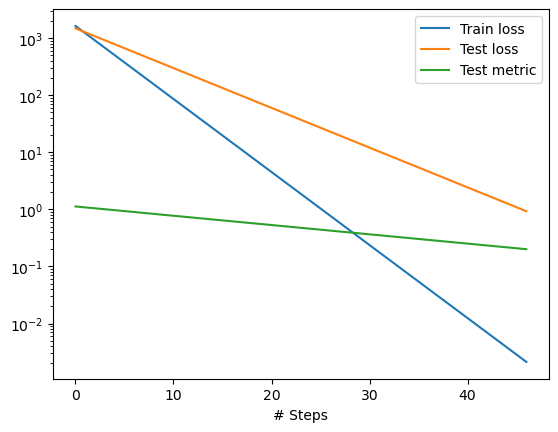

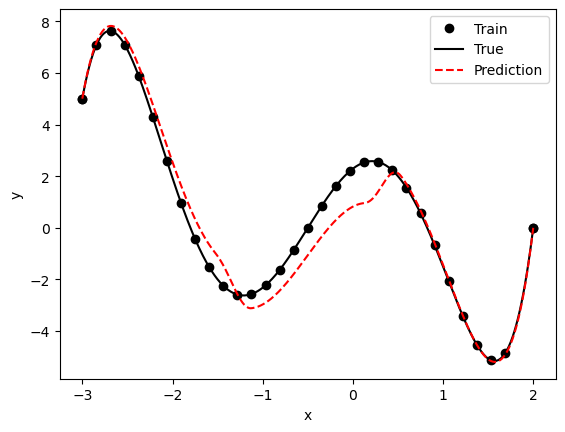

In [2]:
npart = 3
pi = np.pi

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx + 9.714*x**3 + 15.486*x**2 - 16.3572*x - 10.988

def boundary(x, on_boundary, npart=npart):
    return on_boundary

def func(x):
    return 0.4857*x**5 + 1.2905*x**4 - 2.7262*x**3 - 5.4940*x**2 + 2.6512*x + 2.2929

geom = dde.geometry.Interval(-3, 2)
bc = dde.icbc.DirichletBC(geom, func, boundary, npart=npart)
data = dde.data.PDE(geom, pde, bc, 30, 2, solution=func, num_test=500)

M = 30
layer_size = [1] + [M]  +  [1]

activation = ["sin", 'linear']

initializer = "Glorot uniform"
R = 10

net = dde.nn.partition_of_unity(npart, geom, data, layer_size, activation, initializer, Rm=R, b=R/100)

model = dde.Model(data, net)

model.compile("L-BFGS", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

losshistory, train_state = model.train(iterations=30000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.001198 s



Training model...

Step      Train loss              Test loss               Test metric   
0         [2.64e+02, 5.97e-01]    [2.79e+02, 5.97e-01]    [3.18e+00]    
1000      [1.22e+00, 3.18e-02]    [1.32e+00, 3.18e-02]    [5.68e-01]    
2000      [5.82e-01, 5.13e-04]    [5.81e-01, 5.13e-04]    [9.35e-02]    
3000      [4.37e-01, 7.55e-04]    [4.20e-01, 7.55e-04]    [6.74e-02]    
4000      [3.13e-01, 7.98e-04]    [2.98e-01, 7.98e-04]    [7.05e-02]    
5000      [1.86e-01, 4.82e-04]    [1.75e-01, 4.82e-04]    [5.50e-02]    
6000      [8.78e-02, 2.01e-04]    [8.26e-02, 2.01e-04]    [3.75e-02]    
7000      [3.84e-02, 4.52e-05]    [3.80e-02, 4.52e-05]    [2.34e-02]    
8000      [2.44e-02, 3.69e-06]    [2.69e-02, 3.69e-06]    [1.74e-02]    
9000      [2.05e-02, 7.40e-08]    [2.37e-02, 7.40e-08]    [1.52e-02]    
10000     [1.66e-02, 7.18e-09]    [1.94e-02, 7.18e-09]    [1.29e-02]    

Best model at step 10000:
  train loss: 1.66e-02
  test loss: 1.94e-02
  test metric: [1.29e-02]

'train

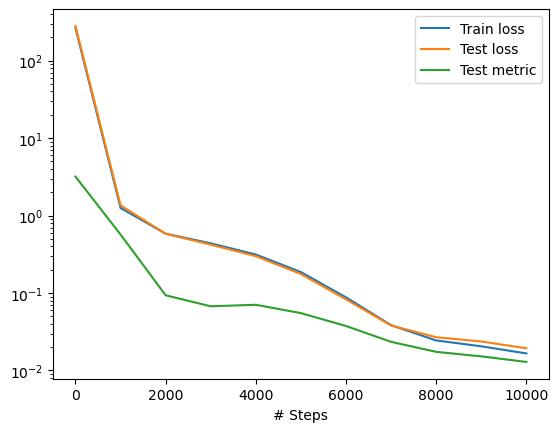

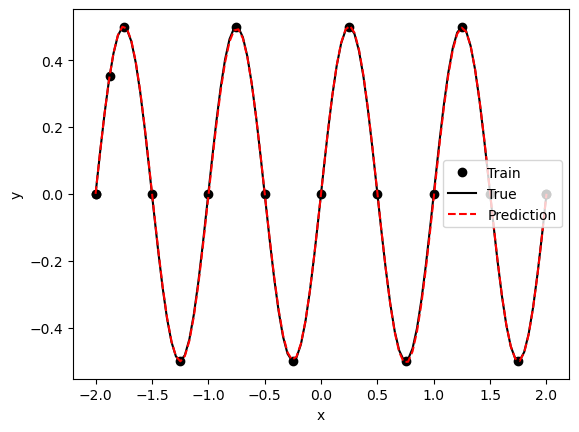

In [49]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return - dy_xx - 4 * np.pi ** 2 * tf.sin(np.pi * x) * tf.cos(np.pi * x)

def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    return np.sin(np.pi * x) * np.cos(np.pi * x)

geom = dde.geometry.Interval(-2, 2)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

M =20
layer_size = [1] + [M]  +  [1]

activation = ["sin", 'linear']

initializer = "Glorot uniform"
R = 10
net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R/1000)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [59]:
geom = dde.geometry.Interval(-3, 2)
print(geom.r)


2
